<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   talk_id         4005 non-null   int64  
 1   title           4005 non-null   object 
 2   speaker_1       4005 non-null   object 
 3   all_speakers    4001 non-null   object 
 4   occupations     3483 non-null   object 
 5   about_speakers  3502 non-null   object 
 6   views           4005 non-null   int64  
 7   recorded_date   4004 non-null   object 
 8   published_date  4005 non-null   object 
 9   event           4005 non-null   object 
 10  native_lang     4005 non-null   object 
 11  available_lang  4005 non-null   object 
 12  comments        3350 non-null   float64
 13  duration        4005 non-null   int64  
 14  topics          4005 non-null   object 
 15  related_talks   4005 non-null   object 
 16  url             4005 non-null   object 
 17  description     4005 non-null   o

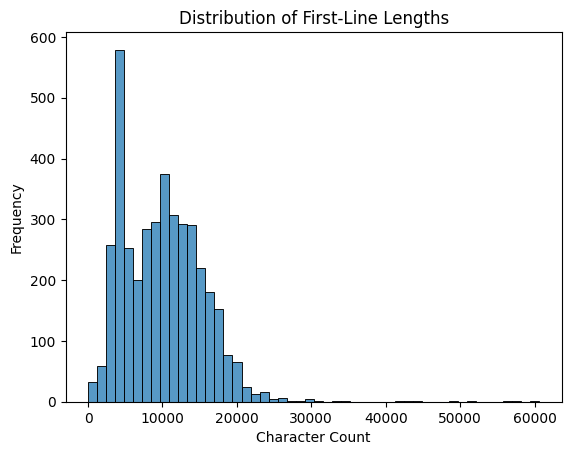

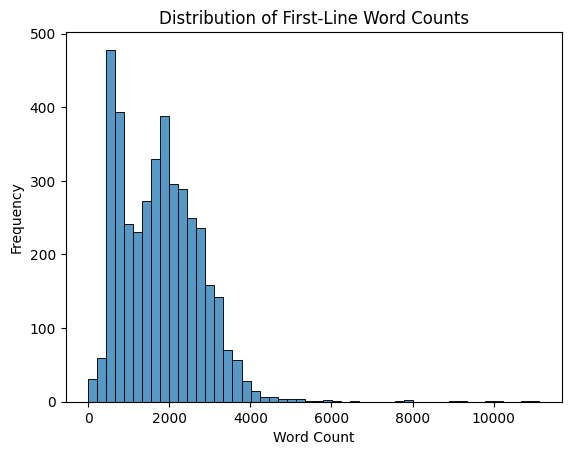

Most common words in first lines:
[('the', 336405), ('and', 240580), ('to', 210934), ('of', 185906), ('a', 171087), ('that', 152605), ('i', 130855), ('in', 126460), ('it', 115815), ('we', 108827), ('you', 108422), ('is', 98330), ('s', 88546), ('this', 74911), ('so', 57089), ('they', 52638), ('for', 51416), ('was', 48949), ('are', 46828), ('but', 45423)]


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Load the CSV (adjust path as needed)
df = pd.read_csv("data/ted_talks_en.csv")

# Check basic info
df.info()

# If you haven't already extracted the first line:
df['first_line'] = df['transcript'].apply(lambda txt: txt.split("\n")[0] if isinstance(txt, str) else "")

# 1) Basic length stats
df['first_line_length'] = df['first_line'].apply(lambda x: len(str(x)))
df['first_line_word_count'] = df['first_line'].apply(lambda x: len(str(x).split()))

print(df[['first_line_length', 'first_line_word_count']].describe())

# 2) Plot distribution of first-line lengths
sns.histplot(df['first_line_length'], bins=50, kde=False)
plt.title("Distribution of First-Line Lengths")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.show()

# 3) Plot distribution of word counts
sns.histplot(df['first_line_word_count'], bins=50, kde=False)
plt.title("Distribution of First-Line Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# 4) Quick look at the top words in first lines
all_words = []
for line in df['first_line']:
    words = re.findall(r'\w+', str(line).lower())
    all_words.extend(words)

counter = Counter(all_words)
print("Most common words in first lines:")
print(counter.most_common(20))


### Semantic Encoding

/home/brandondey/Documents/TED/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 126/126 [02:12<00:00,  1.05s/it]
/home/brandondey/Documents/TED/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/brandondey/Documents/TED/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


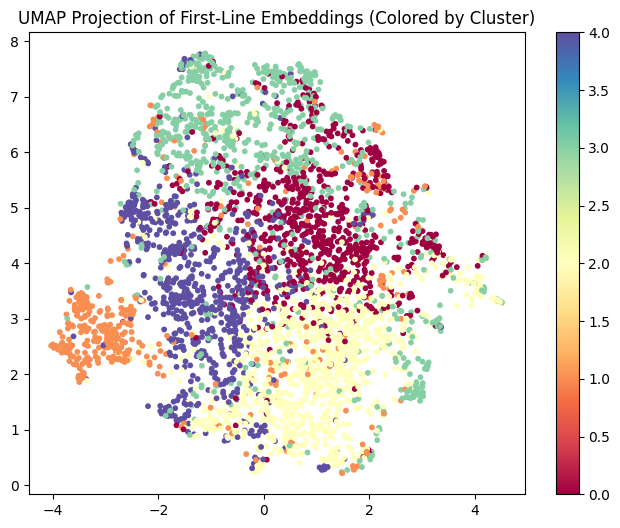

Cluster 0 sample lines:
   Good morning. How are you? (Audience) Good. It's been great, hasn't it? I've been blown away by the whole thing. In fact, I'm leaving. (Laughter) There have been three themes running through the conference, which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we've had and in all of the people here; just the variety of it and the range of it. The second is that it's put us in a place where we have no idea what's going to happen in terms of the future. No idea how this may play out. I have an interest in education. Actually, what I find is, everybody has an interest in education. Don't you? I find this very interesting. If you're at a dinner party, and you say you work in education — actually, you're not often at dinner parties, frankly. (Laughter) If you work in education, you're not asked. (Laughter) And you're never asked back, curiously. That's strange to me. But if you are,

In [2]:
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1) Encode first lines into embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # or any other pretrained model
lines = df['first_line'].fillna("").tolist()
embeddings = model.encode(lines, show_progress_bar=True)

# embeddings is now a 2D numpy array: shape (#lines, embedding_dim)

# 2) Dimensionality reduction with UMAP (just for visualization)
reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.1, random_state=42)
umap_embeds = reducer.fit_transform(embeddings)

# 3) Clustering with KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(embeddings)

# 4) Plot the 2D UMAP projection colored by cluster label
plt.figure(figsize=(8, 6))
plt.scatter(umap_embeds[:,0], umap_embeds[:,1], c=labels, cmap='Spectral', s=10)
plt.colorbar()
plt.title("UMAP Projection of First-Line Embeddings (Colored by Cluster)")
plt.show()

# 5) Inspect lines in each cluster
df['cluster'] = labels
for c in range(5):
    sample_lines = df[df['cluster'] == c]['first_line'].head(5)
    print(f"Cluster {c} sample lines:")
    for line in sample_lines:
        print("  ", line)
    print("-"*50)


### Perplexity

In [3]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch
import math

model_name = "gpt2"
tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

def calculate_perplexity(text):
    encodings = tokenizer(text, return_tensors='pt')
    max_length = model.config.n_positions
    stride = 512  # or some chunk size that fits in GPU/CPU memory

    nlls = []
    for i in range(0, encodings.input_ids.size(1), stride):
        begin = i
        end = min(i+stride, encodings.input_ids.size(1))
        input_ids = encodings.input_ids[:,begin:end]
        target_ids = input_ids.clone()
        
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss * (end - begin)
        nlls.append(neg_log_likelihood)

    ppl = torch.exp(torch.stack(nlls).sum() / end)
    return ppl.item()

# Then, for each line:
df['perplexity'] = df['first_line'].apply(calculate_perplexity)
# Sort or filter by perplexity to find "most unexpected" lines
print(df.sort_values('perplexity', ascending=False)[['first_line', 'perplexity']].head(10))




Token indices sequence length is longer than the specified maximum sequence length for this model (2716 > 1024). Running this sequence through the model will result in indexing errors
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


                                             first_line  perplexity
3510  “All the World’s a Stage” from "As You Like It...  147.271957
3554  "The New Colossus" by Emma Lazarus Not like th...  141.593262
3493  My name is Safia Elhillo, and this poem is cal...  121.733894
3502  "The Second Coming" by William Butler Yeats Tu...  106.089066
3359  First Kiss Her mouth fell into my mouth like a...  104.325050
3458  I'm Denice Frohman, and this is "Accents." my ...   99.138565
3521  "The Road Not Taken" By Robert Frost Two roads...   98.107040
3623  I'm Clint Smith and this is "Ode to the Only B...   80.808350
2000  When I was only three or four, I fell in love ...   71.432846
3497  Hi I'm Andrea Gibson and this is my poem "The ...   66.847221


In [18]:

# include the talk title, speaker, and the first sentence, and url
for i, row in df.sort_values('perplexity', ascending=False)[['title', 'speaker_1', 'first_line', 'perplexity', 'url']].head(100).iterrows():
    print(f"'{row['first_line'].split('. ')[0]}'")
    print(f"From {row['title']} by {row['speaker_1']}")
    print(row['url'])
    print(f"Perplexity: {row['perplexity']:.2f}")
    print("-" * 50)


'“All the World’s a Stage” from "As You Like It" by William Shakespeare All the world’s a stage, And all the men and women merely players; They have their exits and their entrances; And one man in his time plays many parts, His acts being seven ages'
From "All the World's a Stage" by William Shakespeare
https://www.ted.com/talks/william_shakespeare_all_the_world_s_a_stage/
Perplexity: 147.27
--------------------------------------------------
'"The New Colossus" by Emma Lazarus Not like the brazen giant of Greek fame, With conquering limbs astride from land to land; Here at our sea-washed, sunset gates shall stand A mighty woman with a torch, whose flame Is the imprisoned lightning, and her name Mother of Exiles'
From "New Colossus" by Emma Lazarus
https://www.ted.com/talks/emma_lazarus_new_colossus/
Perplexity: 141.59
--------------------------------------------------
'My name is Safia Elhillo, and this poem is called "to make use of water." dilute i forget the arabic word for economy 

In [24]:
import pandas as pd
from reportlab.lib.pagesizes import letter
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.enums import TA_LEFT
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer

# Assume df is your DataFrame already loaded and with a 'perplexity' column.
# For example:
# df = pd.read_csv("path/to/your_transcripts.csv")

# Sort and select top 100 based on perplexity
df_sorted = df.sort_values('perplexity', ascending=False)[['title', 'speaker_1', 'first_line', 'perplexity', 'url']].tail(100)

# Create a PDF document
report_name  = "ted_talks_report_tail.pdf"
doc = SimpleDocTemplate(report_name, pagesize=letter,
                        rightMargin=40, leftMargin=40, topMargin=40, bottomMargin=40)

# Define styles
styles = getSampleStyleSheet()

# Standard style for metadata
custom_style = ParagraphStyle(
    name="Custom",
    parent=styles["Normal"],
    fontSize=10,
    leading=12,
    alignment=TA_LEFT,
)

# Opener style for the first line: larger font and bold
opener_style = ParagraphStyle(
    name="OpenerStyle",
    parent=styles["Normal"],
    fontSize=16,
    leading=20,
    alignment=TA_LEFT,
    fontName="Helvetica-Bold",
)

# Build the PDF content
content = []
title_paragraph = Paragraph("<b>Top 100 TED Talk Openers by Perplexity</b>", styles["Title"])
content.append(title_paragraph)
content.append(Spacer(1, 24))

for i, row in df_sorted.iterrows():
    # Get the first sentence (or first part before a period followed by a space)
    opener = row['first_line'].split('. ')[0]
    
    # Create a paragraph for the opener in large, bold text.
    opener_paragraph = Paragraph(f"“{opener}”", opener_style)
    
    # Create a paragraph for the metadata.
    metadata_text = (
        f"<br/><b>From:</b> {row['title']} by {row['speaker_1']}<br/>"
        f"<b>URL:</b> <a href='{row['url']}' color='blue'>{row['url']}</a><br/>"
        f"<b>Perplexity:</b> {row['perplexity']:.2f}<br/><br/>"
        f"<hr/>"
    )
    metadata_paragraph = Paragraph(metadata_text, custom_style)
    
    content.append(opener_paragraph)
    content.append(Spacer(1, 12))
    content.append(metadata_paragraph)
    content.append(Spacer(1, 12))

# Build the PDF
doc.build(content)

print("PDF generated:", report_name)


PDF generated: ted_talks_report_tail.pdf
